In [1]:
!pip install opencv-python

In [2]:
##Librerias
import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

C:\Users\pablo.ormeno\AppData\Local\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:

#dataset = 'DataSet_Todos'
#dataset = 'DataSet_RoboFlow'
dataset = 'DataSet_Kaagle_2.0'

In [4]:
def TrainValTestSplit(root_dir, classes_dir, val_ratio=0.20, test_ratio=0.20):
    for cls in classes_dir:
        
        print("aqui",dataset,cls)
        train_path = os.path.join(dataset+'\Division_Datos\Entrenamiento', cls)
        val_path = os.path.join(dataset+'\Division_Datos\Validacion', cls)
        test_path = os.path.join(dataset+'\Division_Datos\Testeo', cls)
        
        train_path
        
        os.makedirs(train_path, exist_ok=True)
        os.makedirs(val_path, exist_ok=True)
        os.makedirs(test_path, exist_ok=True)

        src = os.path.join(root_dir, cls)
    

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        
        allFileNames = allFileNames[0:500]

        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames) * (1 - (val_ratio + test_ratio))), int(len(allFileNames) * (1 - test_ratio))])
        

        train_FileNames = [os.path.join(src, name) for name in train_FileNames.tolist()]
        val_FileNames = [os.path.join(src, name) for name in val_FileNames.tolist()]
        test_FileNames = [os.path.join(src, name) for name in test_FileNames.tolist()]
        

        print(cls.upper(), ':')
        print('Total Imagenes: ', len(allFileNames))
        print('Entrenamiento: ', len(train_FileNames))
        print('Validación: ', len(val_FileNames))
        print('Testeo: ', len(test_FileNames))

        for name in train_FileNames:
            shutil.copy(name, train_path)

        for name in val_FileNames:
            shutil.copy(name, val_path)

        for name in test_FileNames:
            shutil.copy(name, test_path)

             
root_dir = dataset+'\Procesadas'
classes_dir = ['cancer', 'non-cancer']  # Classes
TrainValTestSplit(root_dir, classes_dir)

aqui DataSet_Kaagle_2.0 cancer
CANCER :
Total Imagenes:  464
Entrenamiento:  278
Validación:  93
Testeo:  93
aqui DataSet_Kaagle_2.0 non-cancer
NON-CANCER :
Total Imagenes:  435
Entrenamiento:  261
Validación:  87
Testeo:  87


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    directory=dataset+'\Division_Datos\Entrenamiento',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

test_data = test_datagen.flow_from_directory(
    directory=dataset+'\Division_Datos\Testeo',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

val_data = val_datagen.flow_from_directory(
    directory=dataset+'\Division_Datos\Validacion',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

Found 745 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 327 images belonging to 2 classes.


In [6]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives + false_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_negatives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_positives / (true_positives + false_negatives + K.epsilon())

# CNN

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
modelo_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
modelo_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo_cnn.keras", monitor='val_accuracy', save_best_only=True, mode='auto')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


epochs_to_test = [1,5,10,15]  # Epoch checkpoints to evaluate
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

# Train and evaluate the model across different epoch checkpoints
for epochs in epochs_to_test:
    modelo_cnn.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluate the model
    train_loss, train_acc = modelo_cnn.evaluate(train_data, verbose=0)
    val_loss, val_acc = modelo_cnn.evaluate(test_data, verbose=0)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epochs: {epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Epochs: {epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_to_test, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('CNN Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_to_test, val_losses, label='Validation Loss', marker='o')
plt.title('CNN Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()




In [93]:

    modelo_cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    modelo_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy', specificity, sensitivity])


    checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo_cnn.keras", monitor='val_accuracy', save_best_only=True, mode='auto')
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    modelo_cnn.fit(
        train_data,
        steps_per_epoch=len(train_data),
        epochs=5,
        validation_data=val_data,
        validation_steps=len(val_data),
        callbacks=[checkpoint_callback, early_stopping_callback]
    )


    TRAIN_loss, TRAIN_accuracy, TRAIN_specificity, TRAIN_sensitivity = modelo_cnn.evaluate(train_data)
    TRAIN_dor = (TRAIN_sensitivity*TRAIN_specificity) / ((1 - TRAIN_sensitivity)*(1 - TRAIN_specificity))
    print("TRAIN")
    print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
    print(f"{round(TRAIN_accuracy*100,2)} & {round(TRAIN_loss,2)} & {round(TRAIN_specificity*100,2)} & {round(TRAIN_sensitivity*100,2)} & {round(TRAIN_dor,2)} \\")


    TEST_loss, TEST_accuracy, TEST_specificity, TEST_sensitivity = modelo_cnn.evaluate(test_data)
    TEST_dor = (TEST_sensitivity*TEST_specificity) / ((1 - TEST_sensitivity)*(1 - TEST_specificity))

    print("TEST")
    print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
    print(f"{round(TEST_accuracy*100,2)} & {round(TEST_loss,2)} & {round(TEST_specificity*100,2)} & {round(TEST_sensitivity*100,2)} & {round(TEST_dor,2)} \\")


Epoch 1/5
17/17 [==============================] - 44s 3s/step - loss: 0.7452 - accuracy: 0.5510 - specificity: 0.6094 - sensitivity: 0.5193 - val_loss: 0.6891 - val_accuracy: 0.4833 - val_specificity: 0.0000e+00 - val_sensitivity: 0.4813
Epoch 2/5
17/17 [==============================] - 46s 3s/step - loss: 0.6874 - accuracy: 0.5640 - specificity: 0.5268 - sensitivity: 0.5724 - val_loss: 0.6773 - val_accuracy: 0.5167 - val_specificity: 0.1066 - val_sensitivity: 0.4966
Epoch 3/5
17/17 [==============================] - 46s 3s/step - loss: 0.6691 - accuracy: 0.5659 - specificity: 0.6133 - sensitivity: 0.5678 - val_loss: 0.6548 - val_accuracy: 0.5444 - val_specificity: 0.1749 - val_sensitivity: 0.5192
Epoch 4/5
17/17 [==============================] - 42s 2s/step - loss: 0.6204 - accuracy: 0.6494 - specificity: 0.6695 - sensitivity: 0.6777 - val_loss: 0.5972 - val_accuracy: 0.7056 - val_specificity: 0.6142 - val_sensitivity: 0.6798
Epoch 5/5
17/17 [==============================] - 8s 48

# RESNET 101

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
resnet101_base = ResNet101(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_resnet101 = Sequential([
    resnet101_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_resnet101.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo_cnn.keras", monitor='val_accuracy', save_best_only=True, mode='auto')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


epochs_to_test = [1,5,10,15]  # Epoch checkpoints to evaluate
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

# Train and evaluate the model across different epoch checkpoints
for epochs in epochs_to_test:
    model_resnet101.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluate the model
    train_loss, train_acc = model_resnet101.evaluate(train_data, verbose=0)
    val_loss, val_acc = model_resnet101.evaluate(test_data, verbose=0)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epochs: {epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Epochs: {epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_to_test, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('RESNET101 Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_to_test, val_losses, label='Validation Loss', marker='o')
plt.title('RESNET101 Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:


# ResNet101 Model
resnet101_base = ResNet101(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_resnet101 = Sequential([
    resnet101_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_resnet101.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy', specificity, sensitivity])

checkpoint_callback = ModelCheckpoint(filepath="resnet101_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_resnet101.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

TRAIN_loss, TRAIN_accuracy, TRAIN_specificity, TRAIN_sensitivity = model_resnet101.evaluate(train_data)
TRAIN_dor = (TRAIN_sensitivity*TRAIN_specificity) / ((1 - TRAIN_sensitivity)*(1 - TRAIN_specificity))
print("TRAIN")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TRAIN_accuracy*100,2)} & {round(TRAIN_loss,2)} & {round(TRAIN_specificity*100,2)} & {round(TRAIN_sensitivity*100,2)} & {round(TRAIN_dor,2)} \\")


TEST_loss, TEST_accuracy, TEST_specificity, TEST_sensitivity = model_resnet101.evaluate(test_data)
TEST_dor = (TEST_sensitivity*TEST_specificity) / ((1 - TEST_sensitivity)*(1 - TEST_specificity))
print("TEST")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TEST_accuracy*100,2)} & {round(TEST_loss,2)} & {round(TEST_specificity*100,2)} & {round(TEST_sensitivity*100,2)} & {round(TEST_dor,2)} \\")


# DENSENET201

In [94]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
# DenseNet201 Model
densenet201_base = DenseNet201(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_densenet201 = Sequential([
    densenet201_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_densenet201.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo_cnn.keras", monitor='val_accuracy', save_best_only=True, mode='auto')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


epochs_to_test = [1,5,10,15]  # Epoch checkpoints to evaluate
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

# Train and evaluate the model across different epoch checkpoints
for epochs in epochs_to_test:
    model_densenet201.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluate the model
    train_loss, train_acc = model_densenet201.evaluate(train_data, verbose=0)
    val_loss, val_acc = model_densenet201.evaluate(test_data, verbose=0)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epochs: {epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Epochs: {epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_to_test, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('DENSENET201 Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_to_test, val_losses, label='Validation Loss', marker='o')
plt.title('DENSENET201 Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [95]:



# DenseNet201 Model
densenet201_base = DenseNet201(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_densenet201 = Sequential([
    densenet201_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_densenet201.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy', specificity, sensitivity])

checkpoint_callback = ModelCheckpoint(filepath="densenet201_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_densenet201.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

TRAIN_loss, TRAIN_accuracy, TRAIN_specificity, TRAIN_sensitivity = model_densenet201.evaluate(train_data)
TRAIN_dor = (TRAIN_sensitivity*TRAIN_specificity) / ((1 - TRAIN_sensitivity)*(1 - TRAIN_specificity))
print("TRAIN")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TRAIN_accuracy*100,2)} & {round(TRAIN_loss,2)} & {round(TRAIN_specificity*100,2)} & {round(TRAIN_sensitivity*100,2)} & {round(TRAIN_dor,2)} \\")


TEST_loss, TEST_accuracy, TEST_specificity, TEST_sensitivity = model_densenet201.evaluate(test_data)
TEST_dor = (TEST_sensitivity*TEST_specificity) / ((1 - TEST_sensitivity)*(1 - TEST_specificity))

print("TEST")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TEST_accuracy*100,2)} & {round(TEST_loss,2)} & {round(TEST_specificity*100,2)} & {round(TEST_sensitivity*100,2)} & {round(TEST_dor,2)} \\")


Epoch 1/5
17/17 [==============================] - 598s 31s/step - loss: 0.4406 - accuracy: 0.7866 - specificity: 0.8367 - sensitivity: 0.7966 - val_loss: 0.5319 - val_accuracy: 0.7111 - val_specificity: 0.4383 - val_sensitivity: 0.6050
Epoch 2/5
17/17 [==============================] - 510s 30s/step - loss: 0.1801 - accuracy: 0.9351 - specificity: 0.9603 - sensitivity: 0.9383 - val_loss: 0.4427 - val_accuracy: 0.8000 - val_specificity: 0.6338 - val_sensitivity: 0.7306
Epoch 3/5
17/17 [==============================] - 444s 26s/step - loss: 0.0795 - accuracy: 0.9759 - specificity: 0.9860 - sensitivity: 0.9783 - val_loss: 0.3598 - val_accuracy: 0.8556 - val_specificity: 0.7111 - val_sensitivity: 0.7657
Epoch 4/5
17/17 [==============================] - 436s 26s/step - loss: 0.0489 - accuracy: 0.9889 - specificity: 0.9906 - sensitivity: 0.9786 - val_loss: 0.3245 - val_accuracy: 0.9000 - val_specificity: 0.7981 - val_sensitivity: 0.8299
Epoch 5/5
17/17 [==============================] - 9

# DENSENET 169

In [96]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
# DenseNet169 Model
densenet169_base = DenseNet169(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_densenet169 = Sequential([
    densenet169_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_densenet169.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath="densenet169_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


epochs_to_test = [1,5,10,15]  # Epoch checkpoints to evaluate
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

# Train and evaluate the model across different epoch checkpoints
for epochs in epochs_to_test:
    model_densenet169.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluate the model
    train_loss, train_acc = model_densenet169.evaluate(train_data, verbose=0)
    val_loss, val_acc = model_densenet169.evaluate(test_data, verbose=0)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epochs: {epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Epochs: {epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_to_test, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('DENSENET169 Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_to_test, val_losses, label='Validation Loss', marker='o')
plt.title('DENSENET169 Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [97]:



# DenseNet169 Model
densenet169_base = DenseNet169(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_densenet169 = Sequential([
    densenet169_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_densenet169.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy', specificity, sensitivity])

checkpoint_callback = ModelCheckpoint(filepath="densenet169_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_densenet169.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

TRAIN_loss, TRAIN_accuracy, TRAIN_specificity, TRAIN_sensitivity = model_densenet169.evaluate(train_data)
TRAIN_dor = (TRAIN_sensitivity*TRAIN_specificity) / ((1 - TRAIN_sensitivity)*(1 - TRAIN_specificity))
print("TRAIN")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TRAIN_accuracy*100,2)} & {round(TRAIN_loss,2)} & {round(TRAIN_specificity*100,2)} & {round(TRAIN_sensitivity*100,2)} & {round(TRAIN_dor,2)} \\")


TEST_loss, TEST_accuracy, TEST_specificity, TEST_sensitivity = model_densenet169.evaluate(test_data)
TEST_dor = (TEST_sensitivity*TEST_specificity) / ((1 - TEST_sensitivity)*(1 - TEST_specificity))

print("TEST")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TEST_accuracy*100,2)} & {round(TEST_loss,2)} & {round(TEST_specificity*100,2)} & {round(TEST_sensitivity*100,2)} & {round(TEST_dor,2)} \\")


Epoch 1/5
17/17 [==============================] - 433s 23s/step - loss: 0.4637 - accuracy: 0.7774 - specificity: 0.8430 - sensitivity: 0.7574 - val_loss: 0.4318 - val_accuracy: 0.8111 - val_specificity: 0.6552 - val_sensitivity: 0.7190
Epoch 2/5
17/17 [==============================] - 368s 22s/step - loss: 0.1737 - accuracy: 0.9295 - specificity: 0.9241 - sensitivity: 0.9108 - val_loss: 0.2947 - val_accuracy: 0.8667 - val_specificity: 0.7860 - val_sensitivity: 0.8044
Epoch 3/5
17/17 [==============================] - 370s 22s/step - loss: 0.1225 - accuracy: 0.9555 - specificity: 0.9749 - sensitivity: 0.9635 - val_loss: 0.3878 - val_accuracy: 0.8278 - val_specificity: 0.6516 - val_sensitivity: 0.7433
Epoch 4/5
17/17 [==============================] - 368s 22s/step - loss: 0.0630 - accuracy: 0.9796 - specificity: 0.9834 - sensitivity: 0.9800 - val_loss: 0.2942 - val_accuracy: 0.8889 - val_specificity: 0.8049 - val_sensitivity: 0.8178
Epoch 5/5
17/17 [==============================] - 7

# DENSENET 121

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
# DenseNet121 Model
densenet121_base = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_densenet121 = Sequential([
    densenet121_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model_densenet121.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath="densenet121_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


epochs_to_test = [1,5,10,15]  # Epoch checkpoints to evaluate
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

# Train and evaluate the model across different epoch checkpoints
for epochs in epochs_to_test:
    model_densenet121.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluate the model
    train_loss, train_acc = model_densenet121.evaluate(train_data, verbose=0)
    val_loss, val_acc = model_densenet121.evaluate(test_data, verbose=0)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epochs: {epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Epochs: {epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_to_test, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('DENSENET121 Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_to_test, val_losses, label='Validation Loss', marker='o')
plt.title('DENSENET121 Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [6]:


# DenseNet121 Model
densenet121_base = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model_densenet121 = Sequential([
    densenet121_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_densenet121.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy', specificity, sensitivity])

checkpoint_callback = ModelCheckpoint(filepath="densenet121_best_model.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_densenet121.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
)


TRAIN_loss, TRAIN_accuracy, TRAIN_specificity, TRAIN_sensitivity = model_densenet121.evaluate(train_data)
TRAIN_dor = (TRAIN_sensitivity*TRAIN_specificity) / ((1 - TRAIN_sensitivity)*(1 - TRAIN_specificity))
print("TRAIN")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TRAIN_accuracy*100,2)} & {round(TRAIN_loss,2)} & {round(TRAIN_specificity*100,2)} & {round(TRAIN_sensitivity*100,2)} & {round(TRAIN_dor,2)} \\")


TEST_loss, TEST_accuracy, TEST_specificity, TEST_sensitivity = model_densenet121.evaluate(test_data)
TEST_dor = (TEST_sensitivity*TEST_specificity) / ((1 - TEST_sensitivity)*(1 - TEST_specificity))

print("TEST")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TEST_accuracy*100,2)} & {round(TEST_loss,2)} & {round(TEST_specificity*100,2)} & {round(TEST_sensitivity*100,2)} & {round(TEST_dor,2)} \\")


Epoch 1/5
17/17 [==============================] - 268s 14s/step - loss: 0.5071 - accuracy: 0.7607 - specificity: 0.7652 - sensitivity: 0.7603 - val_loss: 0.6664 - val_accuracy: 0.6333 - val_specificity: 0.2988 - val_sensitivity: 0.5646
Epoch 2/5
17/17 [==============================] - 235s 14s/step - loss: 0.2245 - accuracy: 0.9239 - specificity: 0.9667 - sensitivity: 0.9578 - val_loss: 0.6489 - val_accuracy: 0.7056 - val_specificity: 0.4196 - val_sensitivity: 0.6211
Epoch 3/5
17/17 [==============================] - 225s 13s/step - loss: 0.1494 - accuracy: 0.9406 - specificity: 0.9685 - sensitivity: 0.9546 - val_loss: 0.5131 - val_accuracy: 0.7889 - val_specificity: 0.5951 - val_sensitivity: 0.7012
Epoch 4/5
17/17 [==============================] - 227s 13s/step - loss: 0.0894 - accuracy: 0.9647 - specificity: 0.9718 - sensitivity: 0.9630 - val_loss: 0.6466 - val_accuracy: 0.7444 - val_specificity: 0.5077 - val_sensitivity: 0.6549
Epoch 5/5
17/17 [==============================] - 3

# INCEPTION V3

In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

24/24 [==============================] - 39s 1s/step - loss: 0.5885 - accuracy: 0.6832 - val_loss: 0.4473 - val_accuracy: 0.7676
Epochs: 1, Train Accuracy: 0.8094, Validation Accuracy: 0.8201
Epochs: 1, Train Loss: 0.4152, Validation Loss: 0.3799
Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 0.4025 - accuracy: 0.8107 - val_loss: 0.3846 - val_accuracy: 0.8135
Epoch 2/5
24/24 [==============================] - 30s 1s/step - loss: 0.3825 - accuracy: 0.8443 - val_loss: 0.3485 - val_accuracy: 0.8563
Epoch 3/5
24/24 [==============================] - 30s 1s/step - loss: 0.3343 - accuracy: 0.8577 - val_loss: 0.3212 - val_accuracy: 0.8654
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.3181 - accuracy: 0.8698 - val_loss: 0.3027 - val_accuracy: 0.8777
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 0.3017 - accuracy: 0.8685 - val_loss: 0.3136 - val_accuracy: 0.8654
Epochs: 5, Train Accuracy: 0.8859, Validation Accuracy: 0.

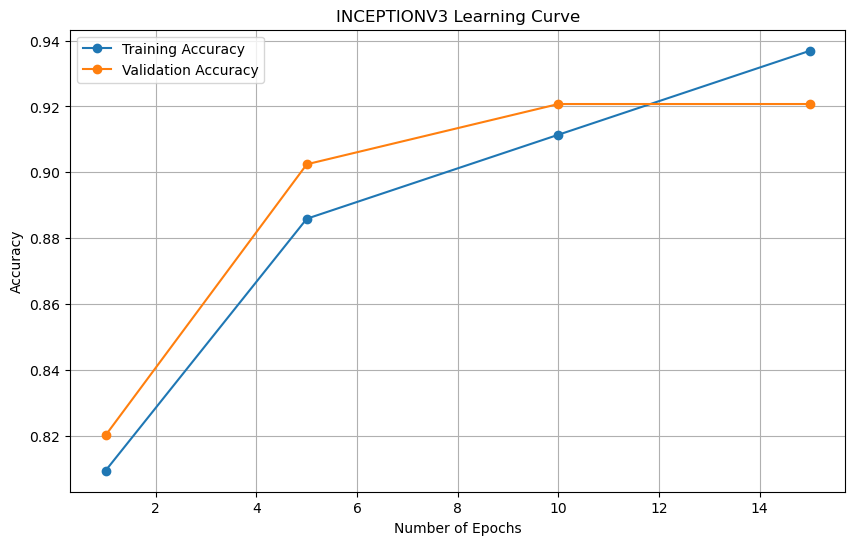

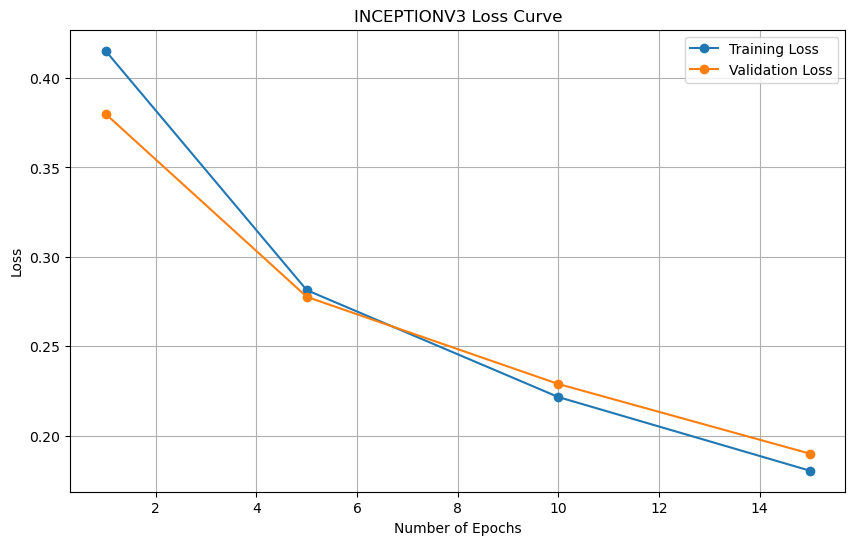

In [8]:
# DenseNet121 Model
# Load InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze base model layers
base_model.trainable = False

# Custom model on top of InceptionV3
model_inception = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_inception.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath="inceptionv3_best_model.keras", monitor='val_accuracy', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

epochs_to_test = [1,5,10,15]  # Epoch checkpoints to evaluate
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

# Train and evaluate the model across different epoch checkpoints
for epochs in epochs_to_test:
    model_inception.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluate the model
    train_loss, train_acc = model_inception.evaluate(train_data, verbose=0)
    val_loss, val_acc = model_inception.evaluate(test_data, verbose=0)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epochs: {epochs}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Epochs: {epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_to_test, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('INCEPTIONV3 Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_test, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_to_test, val_losses, label='Validation Loss', marker='o')
plt.title('INCEPTIONV3 Loss Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [8]:


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives + false_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return true_positives / (true_positives + false_negatives + K.epsilon())

# Load InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze base model layers
base_model.trainable = False

# Custom model on top of InceptionV3
model_inception = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_inception.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy', specificity, sensitivity])

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath="inceptionv3_best_model.keras", monitor='val_accuracy', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

# Training and validation steps (use your train_datagen and val_datagen as before)
model_inception.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

TRAIN_loss, TRAIN_accuracy, TRAIN_specificity, TRAIN_sensitivity = model_inception.evaluate(train_data)
TRAIN_dor = (TRAIN_sensitivity*TRAIN_specificity) / ((1 - TRAIN_sensitivity)*(1 - TRAIN_specificity))
print("TRAIN")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TRAIN_accuracy*100,2)} & {round(TRAIN_loss,2)} & {round(TRAIN_specificity*100,2)} & {round(TRAIN_sensitivity*100,2)} & {round(TRAIN_dor,2)} \\")


TEST_loss, TEST_accuracy, TEST_specificity, TEST_sensitivity = model_inception.evaluate(test_data)
TEST_dor = (TEST_sensitivity*TEST_specificity) / ((1 - TEST_sensitivity)*(1 - TEST_specificity))

print("TEST")
print(f"Accuracy --- Loss --- Specificity --- Sensitivity --- DOR --- ")
print(f"{round(TEST_accuracy*100,2)} & {round(TEST_loss,2)} & {round(TEST_specificity*100,2)} & {round(TEST_sensitivity*100,2)} & {round(TEST_dor,2)} \\")


Epoch 1/5
17/17 [==============================] - 27s 1s/step - loss: 0.5847 - accuracy: 0.6902 - specificity: 0.7171 - sensitivity: 0.6769 - val_loss: 0.3987 - val_accuracy: 0.8111 - val_specificity: 0.8463 - val_sensitivity: 0.7798
Epoch 2/5
17/17 [==============================] - 22s 1s/step - loss: 0.3883 - accuracy: 0.8293 - specificity: 0.8370 - sensitivity: 0.8322 - val_loss: 0.3550 - val_accuracy: 0.8444 - val_specificity: 0.8358 - val_sensitivity: 0.8855
Epoch 3/5
17/17 [==============================] - 21s 1s/step - loss: 0.3942 - accuracy: 0.8404 - specificity: 0.8461 - sensitivity: 0.8328 - val_loss: 0.3348 - val_accuracy: 0.8556 - val_specificity: 0.8464 - val_sensitivity: 0.8820
Epoch 4/5
17/17 [==============================] - 22s 1s/step - loss: 0.3440 - accuracy: 0.8646 - specificity: 0.8750 - sensitivity: 0.8504 - val_loss: 0.3112 - val_accuracy: 0.8667 - val_specificity: 0.9012 - val_sensitivity: 0.8500
Epoch 5/5
17/17 [==============================] - 16s 947ms

In [ ]:
#== from tensorflow.keras.applications import VGG16
#== from tensorflow.keras.models import Sequential
#== from tensorflow.keras.layers import Dense, Flatten, Dropout
#== from tensorflow.keras.optimizers import Adam

#== # Load VGG16 model with pre-trained ImageNet weights
#== base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

#== # Freeze base model layers
#== base_model.trainable = False

#== # Custom model on top of VGG16
#== model_vgg = Sequential([
#==     base_model,
#==     Flatten(),
#==     Dense(512, activation='relu'),
#==     Dropout(0.5),
#==     Dense(1, activation='sigmoid')
#== ])

#== model_vgg.compile(optimizer=Adam(learning_rate=0.0001),
#==                   loss='binary_crossentropy',
#==                   metrics=['accuracy', specificity, sensitivity])

#== # Train the VGG16 model
#== model_vgg.fit(
#==     train_data,
#==     steps_per_epoch=len(train_data),
#==     epochs=2,
#==     validation_data=val_data,
#==     validation_steps=len(val_data),
#==     callbacks=[checkpoint_callback, early_stopping_callback]
#== )

In [ ]:
#== from tensorflow.keras.applications import MobileNet
#== from tensorflow.keras.models import Sequential
#== from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
#== from tensorflow.keras.optimizers import Adam

#== # Load MobileNet model with pre-trained ImageNet weights
#== base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

#== # Freeze base model layers
#== base_model.trainable = False

#== # Custom model on top of MobileNet
#== model_mobilenet = Sequential([
#==     base_model,
#==     GlobalAveragePooling2D(),
#==     Dense(512, activation='relu'),
#==     Dropout(0.5),
#==     Dense(1, activation='sigmoid')
#== ])

#== model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001),
#==                         loss='binary_crossentropy',
#==                         metrics=['accuracy', specificity, sensitivity])

#== # Train the MobileNet model
#== model_mobilenet.fit(
#==     train_data,
#==     steps_per_epoch=len(train_data),
#==     epochs=2,
#==     validation_data=val_data,
#==     validation_steps=len(val_data),
#==     callbacks=[checkpoint_callback, early_stopping_callback]
#== )

# MACHINE LEARNING METHODS

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Extract deep features from the last layer of the pre-trained model
model_feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Generate features for training and validation sets
train_features = model_feature_extractor.predict(train_data)
val_features = model_feature_extractor.predict(val_data)
test_features = model_feature_extractor.predict(test_data)

# Flatten the features to use them in ML models
X_train = np.reshape(train_features, (train_features.shape[0], -1))
X_val = np.reshape(val_features, (val_features.shape[0], -1))
X_test = np.reshape(test_features, (test_features.shape[0], -1))


6/6 [==============================] - 20s 3s/step


In [22]:
len(X_train[0])

32768

In [23]:
# Retrieve the labels from the data generators
y_train = train_data.classes
y_val = val_data.classes
y_test = test_data.classes


# Check shapes of the extracted features and labels
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (539, 32768)
y_train shape: (539,)
X_val shape: (180, 32768)
y_val shape: (180,)
X_test shape: (180, 32768)
y_test shape: (180,)


In [24]:
len(X_val)
len(X_test)

180

In [25]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val) 
X_test_scaled = scaler.fit_transform(X_test) 



from sklearn.decomposition import PCA

pca = PCA(n_components=50)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [26]:
def binary_crossentropy(y_true, y_pred):
    # Ensure that the predictions are clipped to avoid log(0)
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


# KNN *

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

# Assuming `X_train_pca`, `X_test_pca`, `y_train`, and `y_test` are preprocessed datasets

# Initialize KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # Use 5 neighbors by default

# Train the KNN model
knn_model.fit(X_train_pca, y_train)

# Predict on TRAIN set
y_pred_TRAIN = knn_model.predict(X_train_pca)
accuracy_TRAIN = accuracy_score(y_train, y_pred_TRAIN)
print(f"KNN Accuracy (TRAIN): {accuracy_TRAIN}")

# Confusion Matrix for TRAIN set
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_TRAIN).ravel()
sensitivity_TRAIN = tp / (tp + fn)  # Sensitivity (Recall)
specificity_TRAIN = tn / (tn + fp)  # Specificity
dor_TRAIN = (sensitivity_TRAIN * specificity_TRAIN) / ((1 - sensitivity_TRAIN) * (1 - specificity_TRAIN))

# Binary Cross-Entropy for TRAIN set
bce_TRAIN = log_loss(y_train, knn_model.predict_proba(X_train_pca)[:, 1])

print(f"KNN Sensitivity (TRAIN): {sensitivity_TRAIN}")
print(f"KNN Specificity (TRAIN): {specificity_TRAIN}")
print(f"KNN Diagnostic Odds Ratio (DOR) (TRAIN): {dor_TRAIN}")
print(f"KNN Binary Cross-Entropy (TRAIN): {bce_TRAIN}")
print(f"Loss (TRAIN): {bce_TRAIN}, Accuracy (TRAIN): {accuracy_TRAIN}, Specificity (TRAIN): {specificity_TRAIN}, Sensitivity (TRAIN): {sensitivity_TRAIN}, DOR (TRAIN): {dor_TRAIN}")
print(f"{round(accuracy_TRAIN*100,2)} & {round(bce_TRAIN,2)} & {round(specificity_TRAIN*100,2)} & {round(sensitivity_TRAIN*100,2)} & {round(dor_TRAIN,2)} \\\\")


# Predict on Validation/Test set
y_pred = knn_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy (TEST): {accuracy}")

# Confusion Matrix for TEST set
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
dor = (sensitivity * specificity) / ((1 - sensitivity) * (1 - specificity))

# Binary Cross-Entropy for TEST set
bce = log_loss(y_test, knn_model.predict_proba(X_test_pca)[:, 1])

print(f"KNN Sensitivity (TEST): {sensitivity}")
print(f"KNN Specificity (TEST): {specificity}")
print(f"KNN Diagnostic Odds Ratio (DOR) (TEST): {dor}")
print(f"KNN Binary Cross-Entropy (TEST): {bce}")

print(f"Loss (TEST): {bce}, Accuracy (TEST): {accuracy}, Specificity (TEST): {specificity}, Sensitivity (TEST): {sensitivity}, DOR (TEST): {dor}")

# LaTeX-style output for easy tabular reporting
print(f"{round(accuracy*100,2)} & {round(bce,2)} & {round(specificity*100,2)} & {round(sensitivity*100,2)} & {round(dor,2)} \\\\")

KNN Accuracy (TRAIN): 0.7012987012987013
KNN Sensitivity (TRAIN): 0.6666666666666666
KNN Specificity (TRAIN): 0.7338129496402878
KNN Diagnostic Odds Ratio (DOR) (TRAIN): 5.513513513513512
KNN Binary Cross-Entropy (TRAIN): 0.5568947157473275
Loss (TRAIN): 0.5568947157473275, Accuracy (TRAIN): 0.7012987012987013, Specificity (TRAIN): 0.7338129496402878, Sensitivity (TRAIN): 0.6666666666666666, DOR (TRAIN): 5.513513513513512
70.13 & 0.56 & 73.38 & 66.67 & 5.51 \\
KNN Accuracy (TEST): 0.4222222222222222
KNN Sensitivity (TEST): 0.5057471264367817
KNN Specificity (TEST): 0.34408602150537637
KNN Diagnostic Odds Ratio (DOR) (TEST): 0.5367899351887153
KNN Binary Cross-Entropy (TEST): 1.9821112147145332
Loss (TEST): 1.9821112147145332, Accuracy (TEST): 0.4222222222222222, Specificity (TEST): 0.34408602150537637, Sensitivity (TEST): 0.5057471264367817, DOR (TEST): 0.5367899351887153
42.22 & 1.98 & 34.41 & 50.57 & 0.54 \\


# DT *

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import numpy as np

# Assuming `X_train_pca`, `X_test_pca`, `y_train`, and `y_test` are preprocessed datasets

# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# Train the Decision Tree model
dt_model.fit(X_train_pca, y_train)

# Predict on TRAIN set
y_pred_TRAIN = dt_model.predict(X_train_pca)
accuracy_TRAIN = accuracy_score(y_train, y_pred_TRAIN)
print(f"Decision Tree Accuracy (TRAIN): {accuracy_TRAIN}")

# Confusion Matrix for TRAIN set
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_TRAIN).ravel()
sensitivity_TRAIN = tp / (tp + fn)  # Sensitivity (Recall)
specificity_TRAIN = tn / (tn + fp)  # Specificity
dor_TRAIN = (sensitivity_TRAIN * specificity_TRAIN) / ((1 - sensitivity_TRAIN) * (1 - specificity_TRAIN))

# Binary Cross-Entropy for TRAIN set
bce_TRAIN = log_loss(y_train, dt_model.predict_proba(X_train_pca)[:, 1])

print(f"Decision Tree Sensitivity (TRAIN): {sensitivity_TRAIN}")
print(f"Decision Tree Specificity (TRAIN): {specificity_TRAIN}")
print(f"Decision Tree Diagnostic Odds Ratio (DOR) (TRAIN): {dor_TRAIN}")
print(f"Decision Tree Binary Cross-Entropy (TRAIN): {bce_TRAIN}")
print(f"Loss (TRAIN): {bce_TRAIN}, Accuracy (TRAIN): {accuracy_TRAIN}, Specificity (TRAIN): {specificity_TRAIN}, Sensitivity (TRAIN): {sensitivity_TRAIN}, DOR (TRAIN): {dor_TRAIN}")
print(f"{round(accuracy_TRAIN*100,2)} & {round(bce_TRAIN,2)} & {round(specificity_TRAIN*100,2)} & {round(sensitivity_TRAIN*100,2)} & {round(dor_TRAIN,2)} \\\\")


# Predict on Validation/Test set
y_pred = dt_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy (TEST): {accuracy}")

# Confusion Matrix for TEST set
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
dor = (sensitivity * specificity) / ((1 - sensitivity) * (1 - specificity))

# Binary Cross-Entropy for TEST set
bce = log_loss(y_test, dt_model.predict_proba(X_test_pca)[:, 1])

print(f"Decision Tree Sensitivity (TEST): {sensitivity}")
print(f"Decision Tree Specificity (TEST): {specificity}")
print(f"Decision Tree Diagnostic Odds Ratio (DOR) (TEST): {dor}")
print(f"Decision Tree Binary Cross-Entropy (TEST): {bce}")

print(f"Loss (TEST): {bce}, Accuracy (TEST): {accuracy}, Specificity (TEST): {specificity}, Sensitivity (TEST): {sensitivity}, DOR (TEST): {dor}")

# LaTeX-style output for easy tabular reporting
print(f"{round(accuracy*100,2)} & {round(bce,2)} & {round(specificity*100,2)} & {round(sensitivity*100,2)} & {round(dor,2)} \\\\")


Decision Tree Accuracy (TRAIN): 0.7625231910946196
Decision Tree Sensitivity (TRAIN): 0.5900383141762452
Decision Tree Specificity (TRAIN): 0.9244604316546763
Decision Tree Diagnostic Odds Ratio (DOR) (TRAIN): 17.61370716510904
Decision Tree Binary Cross-Entropy (TRAIN): 0.43734457837328583
Loss (TRAIN): 0.43734457837328583, Accuracy (TRAIN): 0.7625231910946196, Specificity (TRAIN): 0.9244604316546763, Sensitivity (TRAIN): 0.5900383141762452, DOR (TRAIN): 17.61370716510904
76.25 & 0.44 & 92.45 & 59.0 & 17.61 \\
Decision Tree Accuracy (TEST): 0.5166666666666667
Decision Tree Sensitivity (TEST): 0.26436781609195403
Decision Tree Specificity (TEST): 0.7526881720430108
Decision Tree Diagnostic Odds Ratio (DOR) (TEST): 1.09375
Decision Tree Binary Cross-Entropy (TEST): 3.500638608716958
Loss (TEST): 3.500638608716958, Accuracy (TEST): 0.5166666666666667, Specificity (TEST): 0.7526881720430108, Sensitivity (TEST): 0.26436781609195403, DOR (TEST): 1.09375
51.67 & 3.5 & 75.27 & 26.44 & 1.09 \\

# SVM

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppose `X_train` and `X_val` are extracted features from the CNN layers or manually engineered features
# `y_train` and `y_val` are the corresponding labels

# Using SVM with a linear kernel
svm_model = SVC(kernel='linear', C=1)

# Train the model
svm_model.fit(X_train_pca, y_train)



# Predict on TRAIN set
y_pred_TRAIN = svm_model.predict(X_train_pca)
accuracy_TRAIN = accuracy_score(y_train, y_pred_TRAIN)
print(f"SVM Accuracy TRAIN: {accuracy_TRAIN}")
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_TRAIN).ravel()  # ravel flattens the confusion matrix
sensitivity_TRAIN = tp / (tp + fn)  # Sensitivity (Recall)
specificity_TRAIN = tn / (tn + fp)  # Specificity
dor_TRAIN = (sensitivity_TRAIN*specificity_TRAIN) / ((1 - sensitivity_TRAIN)*(1 - specificity_TRAIN))
print(f"SVM Sensitivity: {sensitivity_TRAIN}")
print(f"SVM Specificity: {specificity_TRAIN}")
print(f"SVM Diagnostic Odds Ratio (DOR): {dor_TRAIN}")
bce_TRAIN = binary_crossentropy(y_train, y_pred_TRAIN)
print(f"SVM Binary Cross-Entropy: {bce_TRAIN}")

print(f"Loss: {bce_TRAIN}, Accuracy: {accuracy_TRAIN}, Specificity: {specificity_TRAIN}, Sensitivity: {sensitivity_TRAIN}, DOR: {dor_TRAIN}")
print(f"{round(accuracy_TRAIN*100,2)} & {round(bce_TRAIN,2)} & {round(specificity_TRAIN*100,2)} & {round(sensitivity_TRAIN*100,2)} & {round(dor_TRAIN,2)} \\\\")

# Predict on validation set
y_pred = svm_model.predict(X_test_pca)
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # ravel flattens the confusion matrix
sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
dor = (sensitivity*specificity) / ((1 - sensitivity)*(1 - specificity))
print(f"SVM Sensitivity: {sensitivity}")
print(f"SVM Specificity: {specificity}")
print(f"SVM Diagnostic Odds Ratio (DOR): {dor}")
bce = binary_crossentropy(y_test, y_pred)
print(f"SVM Binary Cross-Entropy: {bce}")



print(f"Loss: {bce}, Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}, DOR: {dor}")
print(f"{round(accuracy*100,2)} & {round(bce,2)} & {round(specificity*100,2)} & {round(sensitivity*100,2)} & {round(dor,2)} \\\\")


SVM Accuracy TRAIN: 0.6289424860853432
SVM Sensitivity: 0.5977011494252874
SVM Specificity: 0.658273381294964
SVM Diagnostic Odds Ratio (DOR): 2.861954887218046
SVM Binary Cross-Entropy: 5.980740564270262
Loss: 5.980740564270262, Accuracy: 0.6289424860853432, Specificity: 0.658273381294964, Sensitivity: 0.5977011494252874, DOR: 2.861954887218046
62.89 & 5.98 & 65.83 & 59.77 & 2.86 \\
SVM Accuracy: 0.4666666666666667
SVM Sensitivity: 0.40229885057471265
SVM Specificity: 0.5268817204301075
SVM Diagnostic Odds Ratio (DOR): 0.749562937062937
SVM Binary Cross-Entropy: 8.59631772730644
Loss: 8.59631772730644, Accuracy: 0.4666666666666667, Specificity: 0.5268817204301075, Sensitivity: 0.40229885057471265, DOR: 0.749562937062937
46.67 & 8.6 & 52.69 & 40.23 & 0.75 \\


# RANDOM FOREST

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=10)

# Train the model
rf_model.fit(X_train_pca, y_train)

# Predict on TRAIN set
y_pred_TRAIN = rf_model.predict(X_train_pca)
accuracy_TRAIN = accuracy_score(y_train, y_pred_TRAIN)
print(f"RF Accuracy TRAIN: {accuracy_TRAIN}")
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_TRAIN).ravel()  # ravel flattens the confusion matrix
sensitivity_TRAIN = (tp / (tp + fn))  # Sensitivity (Recall)
specificity_TRAIN = (tn / (tn + fp))  # Specificity
dor_TRAIN = (sensitivity_TRAIN*specificity_TRAIN) / ((1 - sensitivity_TRAIN)*(1 - specificity_TRAIN))
print(f"RF Sensitivity: {sensitivity_TRAIN}")
print(f"RF Specificity: {specificity_TRAIN}")
print(f"RF Diagnostic Odds Ratio (DOR): {dor_TRAIN}")
bce_TRAIN = binary_crossentropy(y_train, y_pred_TRAIN)
print(f"RF Binary Cross-Entropy: {bce_TRAIN}")

print(f"Loss: {bce_TRAIN}, Accuracy: {accuracy_TRAIN}, Specificity: {specificity_TRAIN}, Sensitivity: {sensitivity_TRAIN}, DOR: {dor_TRAIN}")
print(f"{round(accuracy_TRAIN*100,2)} & {round(bce_TRAIN,2)} & {round(specificity_TRAIN*100,2)} & {round(sensitivity_TRAIN*100,2)} & {round(dor_TRAIN,2)} \\\\")

# Predict on validation set
y_pred = rf_model.predict(X_test_pca)
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"RF Accuracy: {accuracy}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # ravel flattens the confusion matrix
sensitivity = (tp / (tp + fn))  # Sensitivity (Recall)
specificity = (tn / (tn + fp))  # Specificity
dor = (sensitivity*specificity) / ((1 - sensitivity)*(1 - specificity))
print(f"RF Sensitivity: {sensitivity}")
print(f"RF Specificity: {specificity}")
print(f"RF Diagnostic Odds Ratio (DOR): {dor}")
bce = binary_crossentropy(y_test, y_pred)
print(f"RF Binary Cross-Entropy: {bce}")

print(f"Loss: {bce}, Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}, DOR: {dor}")
print(f"{round(accuracy*100,2)} & {round(bce,2)} & {round(specificity*100,2)} & {round(sensitivity*100,2)} & {round(dor,2)} \\\\")


RF Accuracy TRAIN: 0.987012987012987
RF Sensitivity: 0.9731800766283525
RF Specificity: 1.0
RF Diagnostic Odds Ratio (DOR): inf
RF Binary Cross-Entropy: 0.20932601624621686
Loss: 0.20932601624621686, Accuracy: 0.987012987012987, Specificity: 1.0, Sensitivity: 0.9731800766283525, DOR: inf
98.7 & 0.21 & 100.0 & 97.32 & inf \\
RF Accuracy: 0.48333333333333334
RF Sensitivity: 0.2988505747126437
RF Specificity: 0.6559139784946236
RF Diagnostic Odds Ratio (DOR): 0.8125000000000001
RF Binary Cross-Entropy: 8.327682801422045
Loss: 8.327682801422045, Accuracy: 0.48333333333333334, Specificity: 0.6559139784946236, Sensitivity: 0.2988505747126437, DOR: 0.8125000000000001
48.33 & 8.33 & 65.59 & 29.89 & 0.81 \\


# XGBOOST

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert the data to XGBoost's DMatrix format
dtrain = xgb.DMatrix(X_train_pca, label=y_train)
dval = xgb.DMatrix(X_val_pca, label=y_val)
dtest = xgb.DMatrix(X_test_pca, label=y_test)

# XGBoost Classifier
params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 5,
    'learning_rate': 0.01
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=50)


# Predict on TRAIN set
y_pred_TRAIN_prob = xgb_model.predict(dtrain)
y_pred_TRAIN = [1 if prob > 0.5 else 0 for prob in y_pred_TRAIN_prob]


accuracy_TRAIN = accuracy_score(y_train, y_pred_TRAIN)
print(f"XGBoost Accuracy TRAIN: {accuracy_TRAIN}")
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_TRAIN).ravel()  # ravel flattens the confusion matrix
sensitivity_TRAIN = (tp / (tp + fn))  # Sensitivity (Recall)
specificity_TRAIN = (tn / (tn + fp))  # Specificity
dor_TRAIN = (sensitivity_TRAIN*specificity_TRAIN) / ((1 - sensitivity_TRAIN)*(1 - specificity_TRAIN))
print(f"XGBoost Sensitivity: {sensitivity_TRAIN}")
print(f"XGBoost Specificity: {specificity_TRAIN}")
print(f"XGBoost Diagnostic Odds Ratio (DOR): {dor_TRAIN}")
bce_TRAIN = binary_crossentropy(y_train, y_pred_TRAIN)
print(f"XGBoost Binary Cross-Entropy: {bce_TRAIN}")

print(f"Loss: {bce_TRAIN}, Accuracy: {accuracy_TRAIN}, Specificity: {specificity_TRAIN}, Sensitivity: {sensitivity_TRAIN}, DOR: {dor_TRAIN}")
print(f"{round(accuracy_TRAIN*100,2)} & {round(bce_TRAIN,2)} & {round(specificity_TRAIN*100,2)} & {round(sensitivity_TRAIN*100,2)} & {round(dor_TRAIN,2)} \\\\")









# Predict on validation set
y_pred_prob = xgb_model.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # ravel flattens the confusion matrix

sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity

dor = (sensitivity*specificity) / ((1 - sensitivity)*(1 - specificity))

print(f"XGBoost Sensitivity: {sensitivity}")
print(f"XGBoost Specificity: {specificity}")
print(f"XGBoost Diagnostic Odds Ratio (DOR): {dor}")

bce = binary_crossentropy(y_test, y_pred)
print(f"XGBoost Binary Cross-Entropy: {dor}")

print(f"Loss: {bce}, Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}, DOR: {dor}")
print(f"{round(accuracy*100,2)} & {round(bce,2)} & {round(specificity*100,2)} & {round(sensitivity*100,2)} & {round(dor,2)} \\\\")



XGBoost Accuracy TRAIN: 0.8979591836734694
XGBoost Sensitivity: 0.896551724137931
XGBoost Specificity: 0.8992805755395683
XGBoost Diagnostic Odds Ratio (DOR): 77.38095238095235
XGBoost Binary Cross-Entropy: 1.644703727676156
Loss: 1.644703727676156, Accuracy: 0.8979591836734694, Specificity: 0.8992805755395683, Sensitivity: 0.896551724137931, DOR: 77.38095238095235
89.8 & 1.64 & 89.93 & 89.66 & 77.38 \\
XGBoost Accuracy: 0.5333333333333333
XGBoost Sensitivity: 0.4942528735632184
XGBoost Specificity: 0.5698924731182796
XGBoost Diagnostic Odds Ratio (DOR): 1.294886363636364
XGBoost Binary Cross-Entropy: 1.294886363636364
Loss: 7.521778023897522, Accuracy: 0.5333333333333333, Specificity: 0.5698924731182796, Sensitivity: 0.4942528735632184, DOR: 1.294886363636364
53.33 & 7.52 & 56.99 & 49.43 & 1.29 \\


# NAIVE BAYES

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

# Train the Naive Bayes model
nb_model = GaussianNB(var_smoothing=0.000001)
nb_model.fit(X_train_pca, y_train)

# Predict on TRAIN set
y_pred_TRAIN = nb_model.predict(X_train_pca)
accuracy_TRAIN = accuracy_score(y_train, y_pred_TRAIN)
print(f"Naive Bayes Accuracy TRAIN: {accuracy_TRAIN}")
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_TRAIN).ravel()  # ravel flattens the confusion matrix
sensitivity_TRAIN = tp / (tp + fn)  # Sensitivity (Recall)
specificity_TRAIN = tn / (tn + fp)  # Specificity
dor_TRAIN = (sensitivity_TRAIN*specificity_TRAIN) / ((1 - sensitivity_TRAIN)*(1 - specificity_TRAIN))
print(f"Naive Bayes Sensitivity: {sensitivity_TRAIN}")
print(f"Naive Bayes Specificity: {specificity_TRAIN}")
print(f"Naive Bayes Diagnostic Odds Ratio (DOR): {dor_TRAIN}")
bce_TRAIN = binary_crossentropy(y_train, y_pred_TRAIN)
print(f"Naive Bayes Binary Cross-Entropy: {bce_TRAIN}")

print(f"Loss: {bce_TRAIN}, Accuracy: {accuracy_TRAIN}, Specificity: {specificity_TRAIN}, Sensitivity: {sensitivity_TRAIN}, DOR: {dor_TRAIN}")
print(f"{round(accuracy_TRAIN*100,2)} & {round(bce_TRAIN,2)} & {round(specificity_TRAIN*100,2)} & {round(sensitivity_TRAIN*100,2)} & {round(dor_TRAIN,2)} \\\\")

# Predict on validation set
y_pred = nb_model.predict(X_test_pca)
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # ravel flattens the confusion matrix
sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
dor = (sensitivity*specificity) / ((1 - sensitivity)*(1 - specificity))
print(f"Naive Bayes Sensitivity: {sensitivity}")
print(f"Naive Bayes Specificity: {specificity}")
print(f"Naive Bayes Diagnostic Odds Ratio (DOR): {dor}")
bce = binary_crossentropy(y_test, y_pred)
print(f"Naive Bayes Binary Cross-Entropy: {bce}")

print(f"Loss: {bce}, Accuracy: {accuracy}, Specificity: {specificity}, Sensitivity: {sensitivity}, DOR: {dor}")
print(f"{round(accuracy*100,2)} & {round(bce,2)} & {round(specificity*100,2)} & {round(sensitivity*100,2)} & {round(dor,2)} \\\\")


Naive Bayes Accuracy TRAIN: 0.5936920222634509
Naive Bayes Sensitivity: 0.6130268199233716
Naive Bayes Specificity: 0.5755395683453237
Naive Bayes Diagnostic Odds Ratio (DOR): 2.148011411310622
Naive Bayes Binary Cross-Entropy: 6.5489109083895825
Loss: 6.5489109083895825, Accuracy: 0.5936920222634509, Specificity: 0.5755395683453237, Sensitivity: 0.6130268199233716, DOR: 2.148011411310622
59.37 & 6.55 & 57.55 & 61.3 & 2.15 \\
Naive Bayes Accuracy: 0.5388888888888889
Naive Bayes Sensitivity: 0.47126436781609193
Naive Bayes Specificity: 0.6021505376344086
Naive Bayes Diagnostic Odds Ratio (DOR): 1.3490011750881317
Naive Bayes Binary Cross-Entropy: 7.432233048605647
Loss: 7.432233048605647, Accuracy: 0.5388888888888889, Specificity: 0.6021505376344086, Sensitivity: 0.47126436781609193, DOR: 1.3490011750881317
53.89 & 7.43 & 60.22 & 47.13 & 1.35 \\
